In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

from merfish_datasets import merfish_datasets
directories = merfish_datasets
print(merfish_datasets)

{'P14NRa_ant': 'merfish_06142023/ant/region0', 'P28NRa_ant': 'merfish_06142023/ant/region1', 'P14NRa_pos': 'merfish_06142023/pos/region0', 'P28NRa_pos': 'merfish_06142023/pos/region1', 'P21NRa_ant': 'merfish_20231114/region0', 'P21DRa_ant': 'merfish_20231114/region2', 'P28DRa_ant': 'merfish_20231114/region1', 'P21NRa_pos': 'merfish_20231120/region0', 'P21DRa_pos': 'merfish_20231120/region1', 'P28DRa_pos': 'merfish_20231120/region2', 'P14NRb_ant': 'merfish_202404051211/region_0', 'P28NRb_ant': 'merfish_202404051211/region_1', 'P14NRb_pos': 'merfish_202404051214/region_0', 'P28NRb_pos': 'merfish_202404051214/region_1', 'P21NRb_ant': 'merfish_202404091526/region_2', 'P21DRb_ant': 'merfish_202404091526/region_1', 'P28DRb_ant': 'merfish_202404091526/region_0', 'P21NRb_pos': 'merfish_202404091601/region_0', 'P21DRb_pos': 'merfish_202404091601/region_2', 'P28DRb_pos': 'merfish_202404091601/region_1', 'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P1

In [3]:
name = 'P28NRa_ant'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
f1   = full_dirc + 'detected_transcripts.csv'
fout = full_dirc + 'detected_transcripts_v1l23_241010.csv'

f_main_l0 = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_l0_hemibrain_240723.h5ad'
f_main_l2 = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_l2_v1_240723.h5ad'

In [4]:
adata_l0 = ad.read(f_main_l0, backed='r')
adata_l2 = ad.read(f_main_l2, backed='r')
adata_l0, adata_l2

(AnnData object with n_obs × n_vars = 112269 × 500 backed at '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_ant_l0_hemibrain_240723.h5ad'
     obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'blended_domains', 'x2', 'y2', 'depth', 'width'
     uns: 'leiden', 'neighbors', 'ref_line', 'rotation', 'xy'
     obsm: 'X_pca', 'X_xy', 'blanks'
     layers: 'jnorm', 'norm'
     obsp: 'connectivities', 'distances', 'xy_connectivities', 'xy_distances',
 AnnData object with n_obs × n_vars = 4875 × 500 backed at '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/P28NRa_ant_l2_v1_240723.h5ad'
     obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_rat

In [5]:
bound_l, bound_r = adata_l2.uns['v1_window']
bound_d = 400

cond = np.all([
    adata_l2.obs['width'] > bound_l, 
    adata_l2.obs['width'] < bound_r, 
    adata_l2.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata_l2[cond]

rotation_angle = adata_l2.uns['rotation']
ref_line = np.array(adata_l2.uns['ref_line'])

# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((19,),
 array([2262, 2263, 2264, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328,
        2329, 2330, 2377, 2378, 2379, 2380, 2381, 2382]))

# get transcripts in V1 L2/3

In [6]:
# go over all tranascripts - select only those that are within these FOVs
chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)

0 0.6984565258026123
1 1.3557536602020264
2 1.9945359230041504
3 2.6262943744659424
4 3.2508842945098877
5 3.8897223472595215
6 4.526956558227539
7 5.148214101791382
8 5.817070007324219
9 6.4414637088775635
10 7.068360805511475
11 7.688642263412476
12 8.306902408599854
13 8.9165620803833
14 9.541982173919678
15 10.154854774475098
16 10.778223276138306
17 11.398504495620728
18 12.008058547973633
19 12.617800951004028
20 13.23789930343628
21 13.84575080871582
22 14.47388482093811
23 15.090332508087158
24 15.707672834396362
25 16.317038536071777
26 16.92953109741211
27 17.54165816307068
28 18.16439414024353
29 18.780694723129272
30 19.410231590270996
31 20.024677753448486
32 20.647984743118286
33 21.257731676101685
34 21.878978967666626
35 22.492308139801025
36 23.11972951889038
37 23.753154277801514
38 24.384505033493042
39 24.998258590698242
40 25.61633062362671
41 26.224169492721558
42 26.837629556655884
43 27.448081254959106
44 28.07630205154419
45 28.711031675338745
46 29.32504510879

In [7]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
84789949,18,0,12088.4160,7427.0527,0.0,512.75920,263.59180,2262,Cdh4,ENSMUST00000000314,2595481503174100051
84789950,19,0,12150.2950,7427.9390,0.0,1085.70690,271.79623,2262,Cdh4,ENSMUST00000000314,2595481503174100082
84789951,24,0,12223.3350,7431.5320,0.0,1762.00820,305.06714,2262,Cdh4,ENSMUST00000000314,-1
84789952,39,0,12043.7610,7450.2640,0.0,99.28781,478.51013,2262,Cdh4,ENSMUST00000000314,-1
84789953,45,0,12084.6940,7463.9487,0.0,478.30072,605.22156,2262,Cdh4,ENSMUST00000000314,2595481503229100018
...,...,...,...,...,...,...,...,...,...,...,...
93719774,29,497,12868.0300,6652.8145,6.0,388.00000,611.00000,2382,Mybpc1,ENSMUST00000238199,2595481502850100040
93719775,41,499,12861.2540,6661.7060,6.0,325.25530,693.32930,2382,Aqp4,ENSMUST00000238946,-1
93719776,31,501,12869.8660,6656.3784,6.0,405.00000,644.00000,2382,Blank-2,Blank-2,2595481502850100040
93719777,40,502,12870.7295,6654.4346,6.0,413.00000,626.00000,2382,Blank-3,Blank-3,2595481502850100040


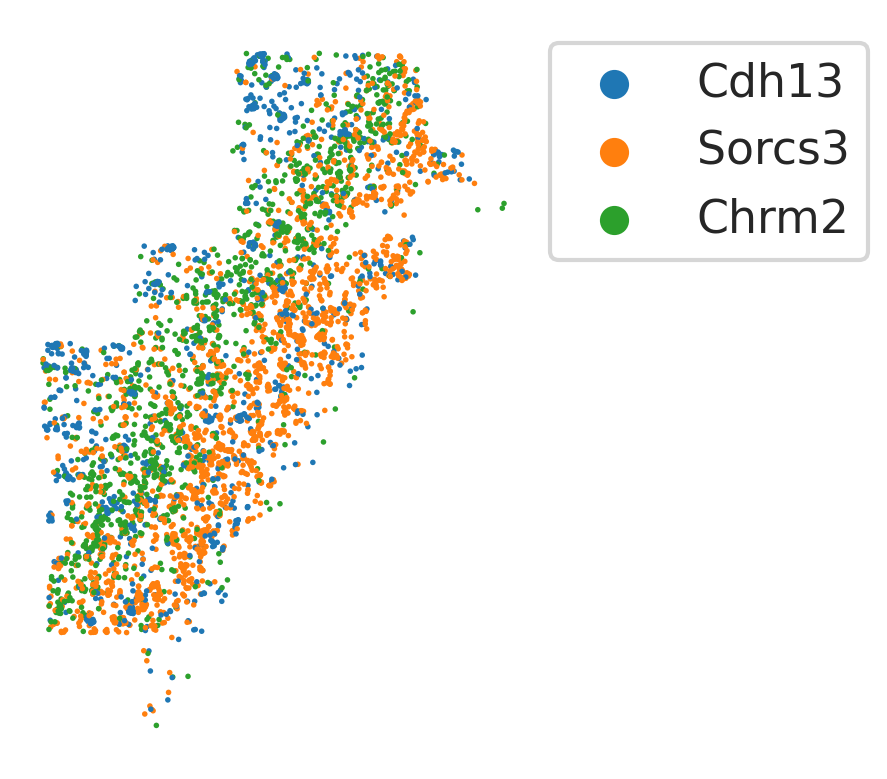

In [8]:
# check results
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']

abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  
fig, ax = plt.subplots()
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='global_x', y='global_y', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# rotate, calc depth and width, and viz

In [9]:
from merfish_datasets import merfish_datasets_params

# (center_x, center_y) raw 
# (x,y) rotation1 
# (x2,y2) rotation2, subtract mean

# get the original operations

# (rotation 1 + rotation 2) -> -(xshift, yshift)

rotations = merfish_datasets_params[name]
alpha1, alpha2 = rotations['rotation'], rotations['rotation2']

xr2, yr2 = utils_merfish.rot2d(adata_l0.obs['x'].values, 
                               adata_l0.obs['y'].values,
                               alpha2) #adata_l0.obs['x']
## check
# plt.scatter(xr2-xshift, adata_l0.obs['x2'])
xshift = np.mean(xr2)
yshift = np.mean(yr2)

In [10]:
# reference line
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [11]:
%%time
x = df_v1l23['global_x'].values
y = df_v1l23['global_y'].values

xr, yr = utils_merfish.rot2d(x, y, alpha1+alpha2)
xr = xr - xshift 
yr = yr - yshift 
XY = np.vstack([xr, yr]).T 

df_v1l23['x'] = xr
df_v1l23['y'] = yr
depth, width = ref_line_obj.dists_to_qps(XY)
df_v1l23['depth'] = depth 
df_v1l23['width'] = width 

cond_spots = np.all([
    df_v1l23['width'] > bound_l, 
    df_v1l23['width'] < bound_r, 
    df_v1l23['depth'] < bound_d, 
], axis=0)

df_v1l23_new = df_v1l23[cond_spots]

CPU times: user 4.49 s, sys: 2.32 s, total: 6.82 s
Wall time: 6.83 s


In [12]:
abc = df_v1l23_new[df_v1l23_new['gene'].isin(query_genes)]  

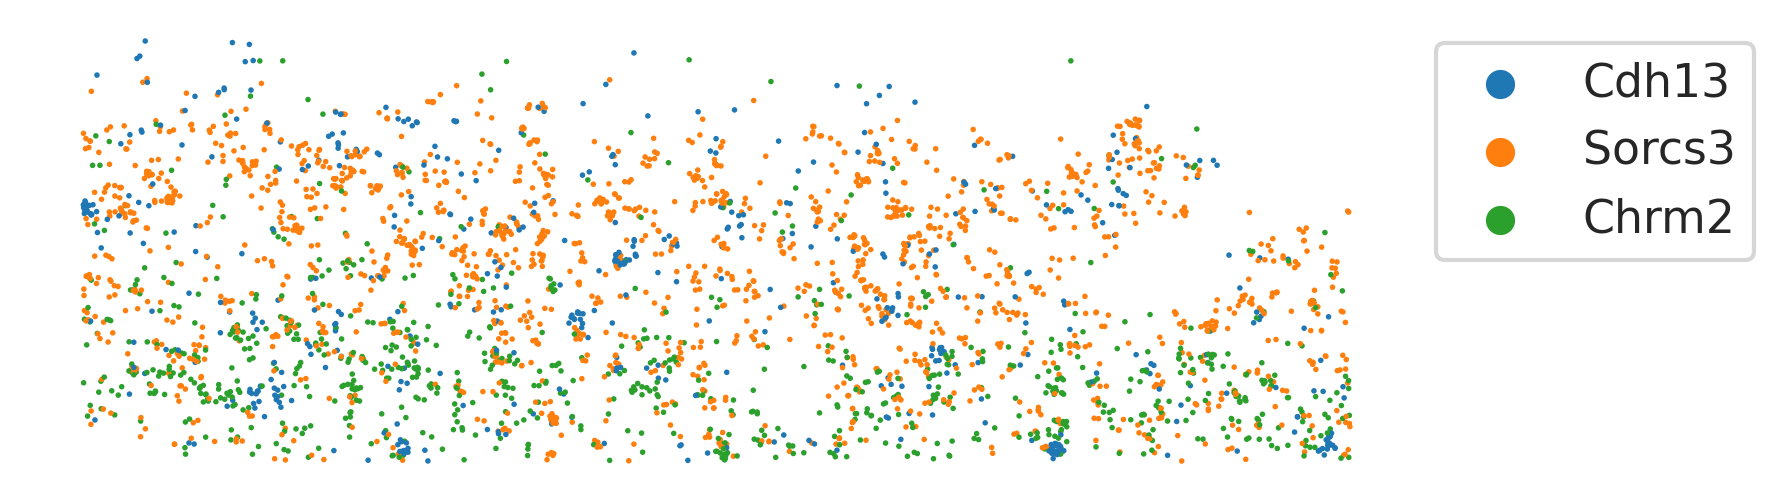

In [13]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# Save results

In [14]:
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
84789949,18,0,12088.4160,7427.0527,0.0,1045.815213,1970.305741,2262,Cdh4,ENSMUST00000000314,2595481503174100051,365.633222,6043.649292
84789950,19,0,12150.2950,7427.9390,0.0,1088.943565,2014.687511,2262,Cdh4,ENSMUST00000000314,2595481503174100082,314.398135,6078.358975
84789951,24,0,12223.3350,7431.5320,0.0,1138.050009,2068.875225,2262,Cdh4,ENSMUST00000000314,-1,252.528732,6117.738336
84789952,39,0,12043.7610,7450.2640,0.0,997.826492,1955.142756,2262,Cdh4,ENSMUST00000000314,-1,388.764958,5998.099537
84789953,45,0,12084.6940,7463.9487,0.0,1017.093950,1993.763302,2262,Cdh4,ENSMUST00000000314,2595481503229100018,347.401792,6010.423092
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93719774,29,497,12868.0300,6652.8145,6.0,2144.554640,1974.107006,2382,Mybpc1,ENSMUST00000238199,2595481502850100040,167.353348,7123.518664
93719775,41,499,12861.2540,6661.7060,6.0,2133.476045,1975.602890,2382,Aqp4,ENSMUST00000238946,-1,167.833382,7112.793587
93719776,31,501,12869.8660,6656.3784,6.0,2143.332831,1977.925312,2382,Blank-2,Blank-2,2595481502850100040,163.792763,7121.676243
93719777,40,502,12870.7295,6654.4346,6.0,2145.317891,1977.161424,2382,Blank-3,Blank-3,2595481502850100040,164.214352,7123.761010


In [16]:
df_v1l23.to_csv(fout, header=True, index=False)
!head $fout

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
18,0,12088.416,7427.0527,0.0,1045.8152127602802,1970.3057414012255,2262,Cdh4,ENSMUST00000000314,2595481503174100051,365.63322229210394,6043.649292485479
19,0,12150.295,7427.939,0.0,1088.9435645331582,2014.687510654434,2262,Cdh4,ENSMUST00000000314,2595481503174100082,314.3981354391254,6078.358974763742
24,0,12223.335,7431.532,0.0,1138.0500091662188,2068.8752246171025,2262,Cdh4,ENSMUST00000000314,-1,252.52873241245535,6117.738336320568
39,0,12043.761,7450.264,0.0,997.8264918162399,1955.1427557174975,2262,Cdh4,ENSMUST00000000314,-1,388.76495812534114,5998.099537059139
45,0,12084.694,7463.9487,0.0,1017.0939495220464,1993.7633017603093,2262,Cdh4,ENSMUST00000000314,2595481503229100018,347.4017920517153,6010.423091556752
46,0,12183.847,7464.585,0.0,1086.755776152167,2064.3249924801676,2262,Cdh4,ENSMUST00000000314,-1,265.90660858116274,6067.531332223302
52,0,12153.186,7470.8125,0.0,1060.671667654367